## Lab6: Bayesianism, with MCMC.

In [1]:
%matplotlib inline
from collections import defaultdict
import json

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib as mpl

#colorbrewer2 Dark2 qualitative color table
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'white'
rcParams['patch.facecolor'] = dark2_colors[0]
rcParams['font.family'] = 'StixGeneral'


def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecesasry plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()
        
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

D:\Users\ZB-TQ-G1010448\Anaconda3\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


### The Bayesian formulation of regression and the posterior predictive distribution

(taken from Am207 class notes)

In the linear regression model we have data $D$, of $n$ observations  
$D=\left\{ ({\bf x}_1, y_1), ({\bf x}_2,y_2), \ldots, ({\bf x}_n, y_n) \right\} $ where ${\bf x}$ 
denotes an input vector of dimension $D$ and $y$ denotes a scalar output (dependent variable). 
All data points are combined into a $D \times n$ matrix $X$. 
The model that determines the relationship between inputs and 
output is given by

$$ y   = \bf x^{T} {\bf w} + \epsilon $$

where ${\bf w}$ is a vector of parameters of the linear model. Usually there is 
a bias or offset is included, but for now we ignore it. 

We assume that the additive noise  $\epsilon$ is iid Gaussian with
zero mean and variance $\sigma_n^2 
\ [ \epsilon \sim N(0, \sigma^2_n) \ ]$.

The likelihood is, because we assume independency, the product 

\begin{eqnarray} L &=& p(\bf y|X,\bf w) = \prod_{i=1}^{n} p(y_i|\bf X_i, \bf w) = \frac{1}{\sqrt{2\pi}\sigma_n}  \prod_{i=1}^{n} 
   \exp{ \left( -\frac{(y_i-\bf X_i^T \bf w)^2}{2\sigma_n^2} \right)}  \nonumber \\ 
   &=& \frac{1}{\sqrt{2\pi}\sigma_n} \exp{\left( -\frac{| \bf y-X^T \bf w|^2 }{2\sigma_n^2} \right)} = N(X^T \bf w,  \sigma_n^2 I)
   \end{eqnarray}
   
where $|x|$ denotes the Euclidean length of vector $\bf x$. 

An alternative way of expressing the likelihood, which is convenient
when sampling ${\bf w}$'s:

\begin{eqnarray} 
p(\bf y|\bf X,\bf w) &=& \frac{1}{\sqrt{2\pi}\sigma_n} \exp{\left( -\frac{| X^{-1} \bf y- \bf w|^2 \,\, (X^{-1} (X^{-1})^{T}) }{2\sigma_n^2} \right)} = N(X^{-1} \bf y,  \sigma_n^2 (X^{-1} (X^{-1})^{T}) )
   \end{eqnarray}

In the Bayesian framework inference we need to specify a prior
over the parameters that expresses our belief about the parameters
before we take any measurements. A wise choice is a zero mean 
Gaussian with covariance matrix $\Sigma$ 

\begin{equation}
 w \sim N(0, \Sigma) 
\end{equation}

We can now continue with the standard Bayesian formalism 

\begin{eqnarray}
 p(\bf w| \bf y,X) &\propto& p(\bf y | X, \bf w) \, p(\bf w) \nonumber \\
                       &\propto& \exp{ \left(- \frac{1}{2 \sigma_n^2}(\bf y-X^T \bf w)^T(\bf y - X^T \bf w) \right)}
                        \exp{\left( -\frac{1}{2} \bf w^T \Sigma^{-1} \bf w \right)}  \nonumber \\ 
 \end{eqnarray}
 
In the next step we `complete the square' and obtain 

\begin{equation}
p(\bf w| \bf y,X)  \propto  \exp \left( -\frac{1}{2} (\bf w - \bar{\bf w})^T  (\frac{1}{\sigma_n^2} X X^T + \Sigma^{-1})(\bf w - \bar{\bf w} )  \right)
\end{equation}

where $\bar{\bf w} = \sigma_n^{-2}( \sigma_n^{-2}XX^T +\Sigma^{-1})^{-1} X \bf y $

This looks like a Gaussian and therefore the posterior is

$$ p(\bf w| X, {\bf y}) \sim {\cal N}( \frac{1}{\sigma_n^2} A^{-1}Xy , A^{-1} ) $$ 

where $A= \sigma_n^{-2}XX^T +\Sigma^{-1}$

To make predictions for a test case we average over all possible parameter predictive distribution
values, weighted by their posterior probability. This is in contrast to non Bayesian schemes, where a single parameter is typically chosen by some criterion. 

Thus the predictive distribution at some $x^{*}$ is given by averaging the output of all possible linear models w.r.t. the  posterior

\begin{eqnarray} 
p(y^{*} | x^{*}, {\bf x,y}) &=& \int p({\bf y}^{*}| {\bf x}^{*}, {\bf w} ) p(\bf w| X, y)dw \nonumber \\
                                    &=& {\cal N} \left(\frac{1}{\sigma_n^2} x^{*^{T}} A^{-1} X {\bf y}, x^{*^T}A^{-1}x^{*} \right),
\end{eqnarray}

which is again Gaussian, with a mean given by the posterior mean multiplied by the test input
and the variance is a quadratic
form of the test input with the posterior covariance matrix, showing that the
predictive uncertainties grow with the magnitude of the test input, as one would
expect for a linear model. 


### Bayesian as an updating of knowledge

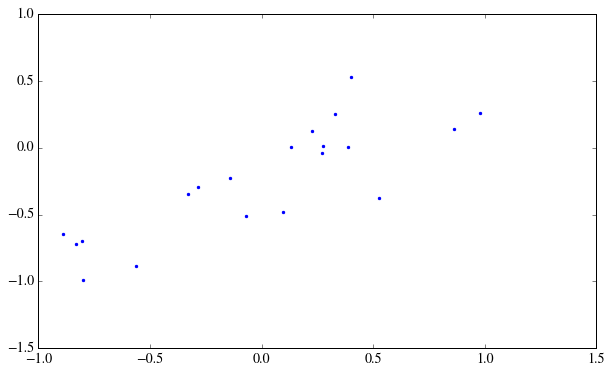

In [2]:
a0=-0.3
a1=0.5
N=20
noiseSD=0.2
priorPrecision=2.0
u=np.random.rand(20)
x=2.*u -1.
def randnms(mu, sigma, n):
    return sigma*np.random.randn(n) + mu
y=a0+a1*x+randnms(0.,noiseSD,N)
plt.scatter(x,y)

In [3]:
from scipy.stats import norm
likelihoodSD = noiseSD # Assume the likelihood precision, beta, is known.
likelihoodPrecision = 1./(likelihoodSD*likelihoodSD)

In [4]:
from _multivariate import multivariate_normal

In [5]:
def cplot(f):
    plt.figure()
    xx,yy=np.mgrid[-1:1:.01,-1:1:.01]
    pos = np.empty(xx.shape + (2,))
    pos[:, :, 0] = xx
    pos[:, :, 1] = yy
    ax=plt.contourf(xx, yy, f(pos))
    #data = [x, y]
    return ax

In [6]:
priorMean = np.zeros(2)
priorSigma = np.eye(2)/priorPrecision #Covariance Matrix
priorPDF = lambda w: multivariate_normal.pdf(w,priorMean,priorSigma)
priorPDF([1,2])

0.0021447551423913074

In [7]:
np.transpose(priorMean)

array([ 0.,  0.])

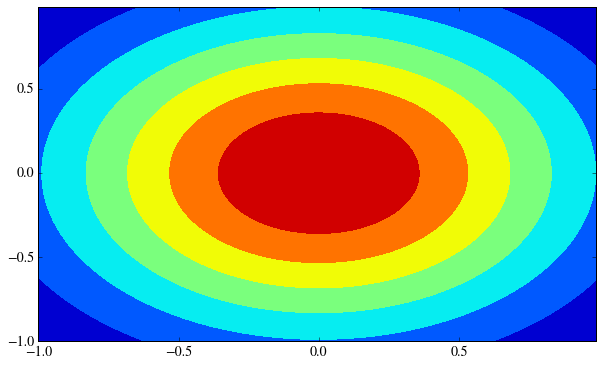

In [8]:
cplot(priorPDF)

In [9]:
def plotSampleLines(mu, sigma, numberOfLines, dataPoints=None):
    #Plot the specified number of lines of the form y = w0 + w1*x in [-1,1]x[-1,1] by
    # drawing w0, w1 from a bivariate normal distribution with specified values
    # for mu = mean and sigma = covariance Matrix. Also plot the data points as
    # blue circles. 
    #print "datap",dataPoints
    fig=plt.figure()

    for i in range(numberOfLines):
        w = np.random.multivariate_normal(mu,sigma)
        func = lambda x: w[0] + w[1]*x
        xx=np.array([-1,1])
        plt.plot(xx,func(xx),'r')
    if dataPoints:
        plt.scatter(dataPoints[0],dataPoints[1])
    ax=plt.gca()
    ax.set_xlim([-1,1])
    ax.set_ylim([-1,1])
    plt.show()

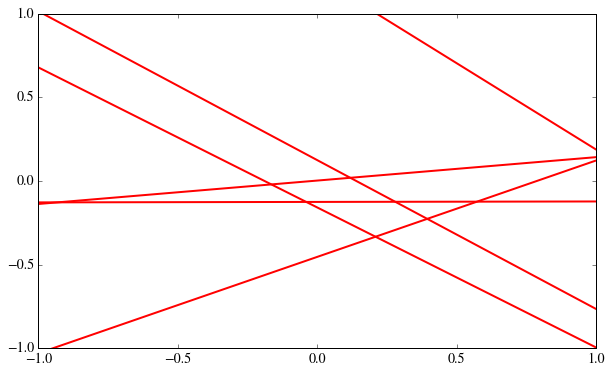

In [10]:
plotSampleLines(priorMean,priorSigma,6)

In [11]:
# Given the mean = priorMu and covarianceMatrix = priorSigma of a prior
# Gaussian distribution over regression parameters; observed data, xtrain
# and ytrain; and the likelihood precision, generate the posterior
# distribution, postW via Bayesian updating and return the updated values
# for mu and sigma. xtrain is a design matrix whose first column is the all
# ones vector.
def update(x,y,likelihoodPrecision,priorMu,priorSigma): 
    postSigmaInv  = np.linalg.inv(priorSigma) + likelihoodPrecision*np.outer(x.T,x)
    postSigma = np.linalg.inv(postSigmaInv)
    postMu = np.dot(np.dot(postSigma,np.linalg.inv(priorSigma)),priorMu) + likelihoodPrecision*np.dot(postSigma,np.outer(x.T,y)).flatten()
    postW = lambda w: multivariate_normal.pdf(w,postMu,postSigma)
    return postW,postMu,postSigma

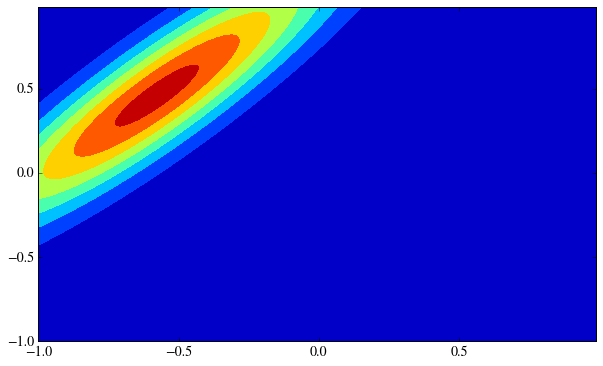

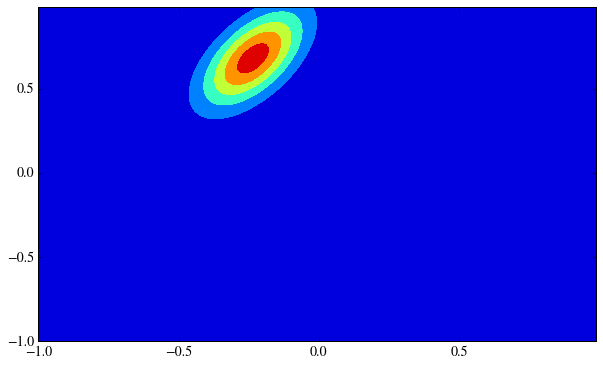

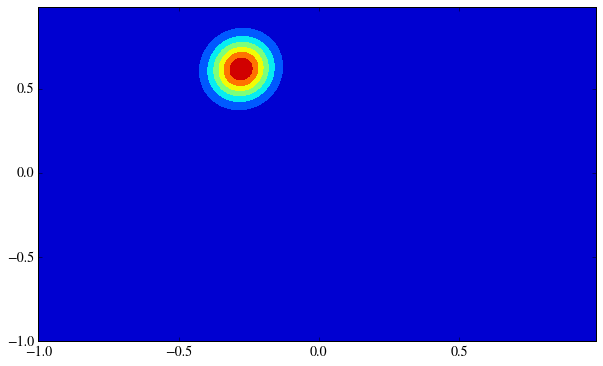

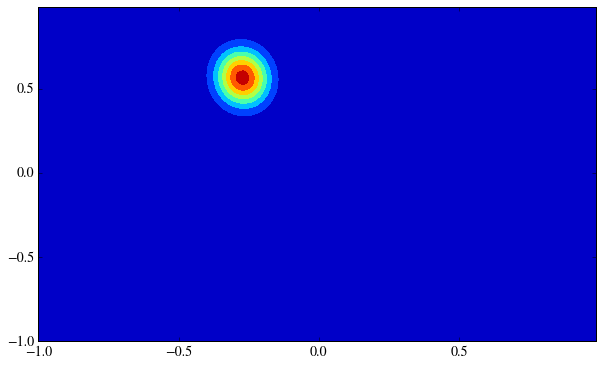

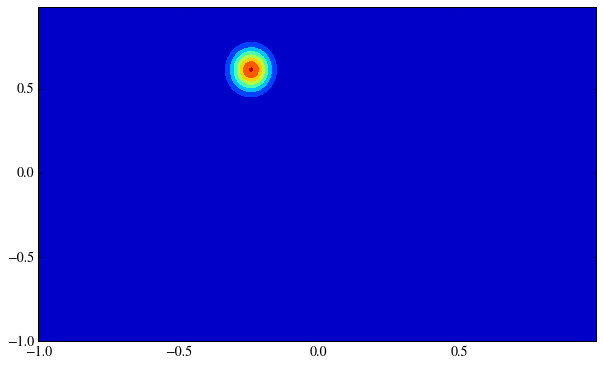

In [12]:
# For each iteration plot  the
# posterior over the first i data points and sample lines whose
# parameters are drawn from the corresponding posterior. 
mu = priorMean
sigma = priorSigma
iterations=2
muhash={}
sigmahash={}
for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]:
    postW,mu,sigma = update(np.array([1,x[i]]),y[i],likelihoodPrecision,mu,sigma)
    muhash[i]=mu
    sigmahash[i]=sigma
    if i in [1,4,7,10,19]:
        cplot(postW)
        #plotSampleLines(mu,sigma,6,(x[0:i],y[0:i]))  
        #print "=========", i, x[0:i],y[0:i]

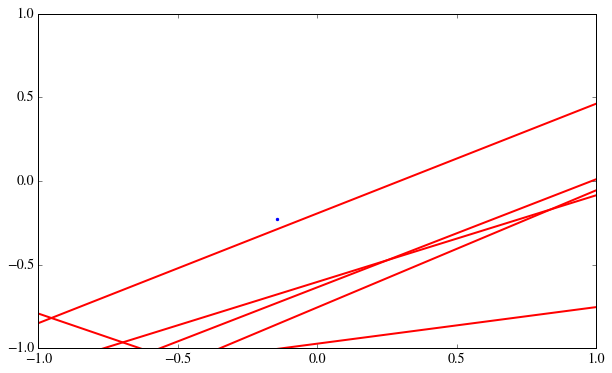

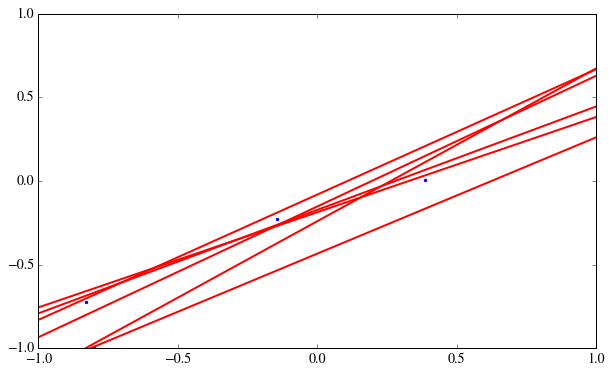

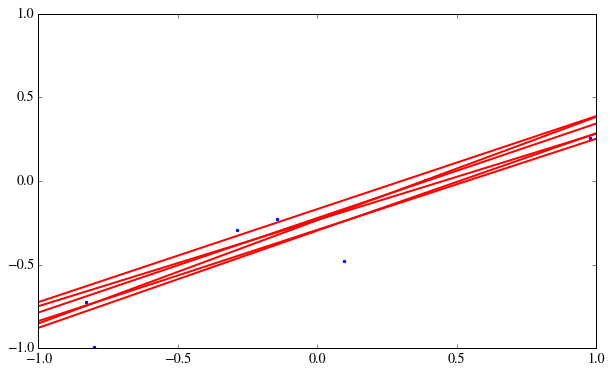

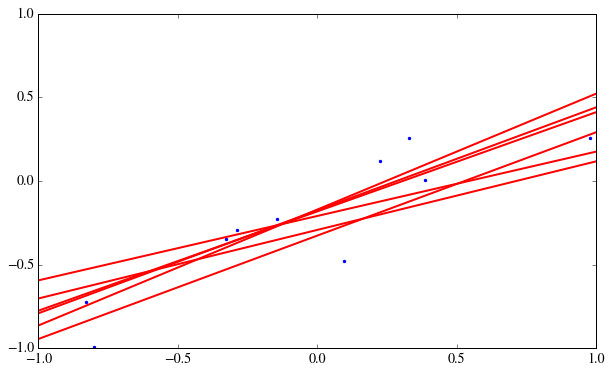

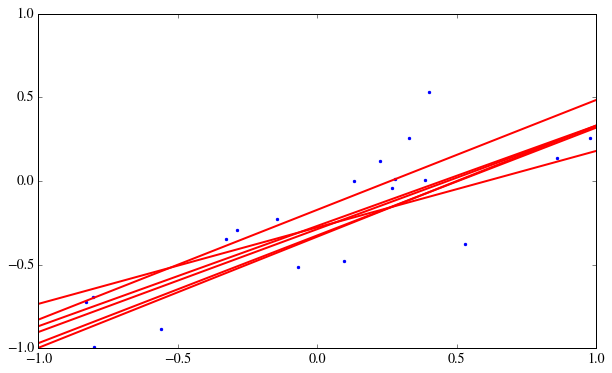

In [13]:
for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]:
    if i in [1,4,7,10,19]:
        plotSampleLines(muhash[i],sigmahash[i],6, (x[0:i],y[0:i]))

### MCMC sampling

Monte Carlo sampling 
is design to  estimate various characteristics of a distribution such as the mean, variance, kurtosis, or any other statistic. 

Markov chains involve a stochastic sequential process where we can
sample states from some stationary distribution.
The goal of MCMC is to design a Markov chain such that the stationary distribution of
the chain is exactly the distribution that we are interesting in sampling from. 
This is called
the **target distribution**. 

In other words, the states sampled from the Markov
chain should follow the same statistics of samples drawn from the target distribution. The idea is to use some clever
methods for setting up the proposal distribution such that no matter how we initialize each
chain, we will convergence to the target distribution. 

### MCMC, MH Sampler

The Metropolis-Hastings (MH) algorithm is the most popular of the MCMC 
methods (Metropolis et al 1953, Hastings 1970). As a matter of fact 
we will see that most MCMC algorithms can be interpreted as special cases
of this algorithm. 

Suppose our goal is to sample from the target density $p(x)$, with $-\infty< x < \infty$ . The
Metropolis-Hastings sampler creates a Markov chain that produces a sequence of values:

$$ x^{(1)} \rightarrow  x^{(2)}  \rightarrow \ldots  \rightarrow  x^{(t)} \ldots $$

where $x^{(t)}$ 
represents the state of a Markov chain at iteration $t$. The samples from the
chain, after burnin, reflect samples from the target distribution $p(x)$.

The MH algorithm, initializes the first state, $x^{(1)}$ 
to some initial value, and then uses a proposal distribution $q(x_s|x_t)$ to sample a candidate
value $x_s$ given the current value of $x_t$ according to $q(x_s|x_t)$. The Markov chain 
then moves towards $x_s$ with the acceptance probability 

$$
A(x_t,x_s) = \min\left[1, \frac{p(x_s) \, q(x_t|x_s)}{p(x_t) q(x_s|x_t) } \right] 
$$

otherwise it remains at $x_t$. 

### M to be precise.

Note that if the transition probability is symmetric $q(x_s|x^{(i)}) = q(x^{(i)}|x_s)$ then
the acceptance probability becomes 

$$ A(x,x_s) = \min\left[1, \frac{p(x_s)}{p(x) } \right] $$

which was the original algorithm proposed by Metropolis, thus the Metropolis algorithm.

A major advantage of the MH sampler is that equation involves only a ratio of
densities. Therefore, any terms independent of $x$ in the functional form of $p(x)$ will drop out.
We do not need to know the normalizing constant of the density or probability. 
The fact that this procedure allows us to sample from unnormalized distributions is
one of its major attractions. Sampling from unnormalized distributions frequently happens
in Bayesian models, where calculating the normalization constant is difficult or impractical.


The MH algorithm is very simple, but it requires careful design of the proposal distribution 
$q(x_s| x)$. 

Later we will see that many MCMC algorithms arise by
considering specific choices of this distribution.  
A way to design these sampling mechanism is to ensure that detailed
balance is satisfied. However, it is also important to design samplers that converge quickly
or the burnin time is short. 

In [15]:
Nmc=200000
burnin=40000
t1 = np.zeros(Nmc)
i=0
#Try 0.1, 1.0, 10.0, 100.0
sig=1.
t1_prev=np.random.randn()
print("Init",t1_prev)

def randnms(mu, sigma):
    return sigma*np.random.randn() + mu

posterior = lambda x: np.exp(-x*x/2.)

proposal=randnms

while i < Nmc:
    #proposal
    t1_star=proposal(t1_prev, sig)
    #New Posterior
    P_star=posterior(t1_star)
    #Old Posterior
    P_prev=posterior(t1_prev)

    A=np.min([P_star/P_prev, 1.0])
    U=np.random.rand()
    
    if U < A :#accept
        t1[i]=t1_star
        t1_prev=t1_star
    else:#reject
        t1[i]=t1_prev
                
    i=i+1

Init 1.038089612307528


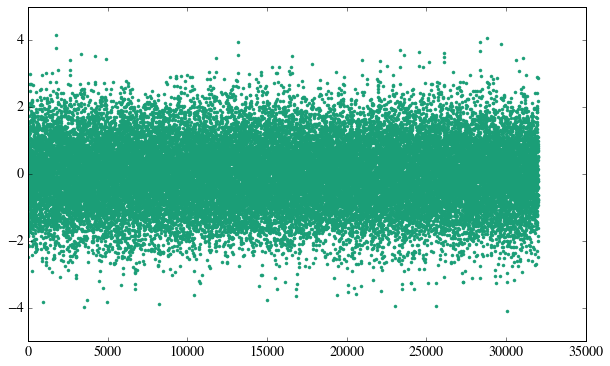

In [16]:
t1clean=t1[burnin:Nmc:5]
plt.plot(range(len(t1clean)),t1clean,'.')

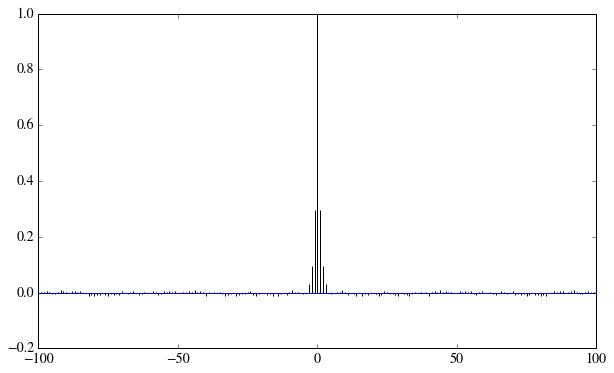

In [17]:
plt.acorr(t1clean-np.mean(t1clean), maxlags=100, lw=1 , normed=True);

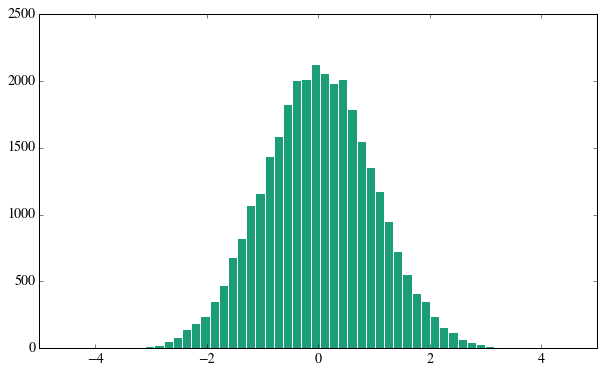

In [18]:
plt.hist(t1clean, bins=50);